# CT/MRI Classification By MobileNetV2

- Here we use the MobileNetV2 architecture to classify whether an image is a CT or MRI scan of a brain tumor.
- This is only an empirical proxy to check if the augmentations generated are unrealistic or not.
- As a result, we will not be training the convolution part, only the FC layers.
- Note that this will not be used as the actual classifier for CT/MRI in the final model.

In [21]:
# Importing necessary libraries

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary

import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score

import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
# Downloading the dataset

import kagglehub

# Download latest version
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1


In [3]:
# Extract image paths and create CT/MRI labels

import glob
from pathlib import Path

# Initialize lists to store paths and labels
image_paths = []
labels = []

# Define the main dataset path
dataset_path = Path(path)

# Define the two main folders
ct_folder = dataset_path / "Dataset" /"Brain Tumor CT scan Images"
mri_folder = dataset_path / "Dataset" / "Brain Tumor MRI images"

# Common image extensions
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.tif']

# Function to get all image files from a directory
def get_image_files(folder_path):
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(str(folder_path / "**" / ext), recursive=True))
    return image_files

# Extract CT images
if ct_folder.exists():
    ct_images = get_image_files(ct_folder)
    image_paths.extend(ct_images)
    labels.extend(['CT'] * len(ct_images))
    print(f"Found {len(ct_images)} CT images")
else:
    print(f"CT folder not found: {ct_folder}")

# Extract MRI images  
if mri_folder.exists():
    mri_images = get_image_files(mri_folder)
    image_paths.extend(mri_images)
    labels.extend(['MRI'] * len(mri_images))
    print(f"Found {len(mri_images)} MRI images")
else:
    print(f"MRI folder not found: {mri_folder}")

print(f"\nTotal images found: {len(image_paths)}")
print(f"CT images: {labels.count('CT')}")
print(f"MRI images: {labels.count('MRI')}")

# Display first few examples
print("\nFirst 5 image paths and labels:")
for i in range(min(5, len(image_paths))):
    print(f"{labels[i]}: {image_paths[i]}")

Found 4618 CT images
Found 5000 MRI images

Total images found: 9618
CT images: 4618
MRI images: 5000

First 5 image paths and labels:
CT: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\Dataset\Brain Tumor CT scan Images\Healthy\ct_healthy (1).jpg
CT: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\Dataset\Brain Tumor CT scan Images\Healthy\ct_healthy (10).jpg
CT: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\Dataset\Brain Tumor CT scan Images\Healthy\ct_healthy (100).jpg
CT: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\Dataset\Brain Tumor CT scan Images\Healthy\ct_healthy (1000).jpg
CT: C:\Users\Ankit Dey\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\Dataset\Brain Tumor CT scan Images\Health

In [4]:
# Creating a dataframe out of the extracted file paths and the labels

data_df = pd.DataFrame(zip(image_paths, labels), columns=['image_paths', 'labels'])
data_df.head()

,image_paths,labels
0,C:\Users\Ankit Dey\.cache\kagglehub\datasets\m...,CT
1,C:\Users\Ankit Dey\.cache\kagglehub\datasets\m...,CT
2,C:\Users\Ankit Dey\.cache\kagglehub\datasets\m...,CT
3,C:\Users\Ankit Dey\.cache\kagglehub\datasets\m...,CT
4,C:\Users\Ankit Dey\.cache\kagglehub\datasets\m...,CT


In [5]:
# Train Test Split (70-30)

train = data_df.sample(frac=0.7, random_state=7)
test = data_df.drop(train.index)

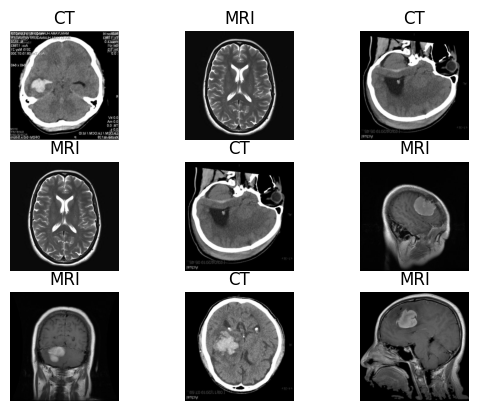

In [6]:
# Data Visualization

n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
c = 0
for row in range(n_rows):
    for col in range(n_cols):
        tuple = train.iloc[c * row + col]
        image = Image.open(tuple['image_paths']).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')
        axarr[row, col].set_title(tuple['labels'])
    c += 1

plt.show()

In [7]:
# Encode classes to numeric values

label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

LabelEncoder()

In [8]:
# Necessary transformations for MobileNetv2

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
# Hyperparameters

LEARNING_RATE = 1e-3
BATCH_SIZE = 32
EPOCHS = 3

In [10]:
# Creating dataset class

class dataset(Dataset):

    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels']))

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, ind):
        img_path = self.dataframe['image_paths'].iloc[ind]
        label = self.labels[ind]
        image = Image.open(img_path).convert('RGB')
        if (self.transform):
            image = self.transform(image).to(device)
        return image, label

In [11]:
# Creating datasets

train_dataset = dataset(dataframe=train, transform=transform)
test_dataset = dataset(dataframe=test, transform=transform)

In [12]:
# Creating Dataloaders

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
# Getting MobileNetV2

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in C:\Users\Ankit Dey/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Work\VS Code\ml-research-project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Work\VS Code\ml-research-project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Checking model parameters

model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
# Freezing all parameters

for param in model.parameters():
    param.requires_grad = False

# Replacing the classifier for binary Classification

model.classifier[1] = nn.Linear(model.last_channel, 2)

In [16]:
# Moving model to device

model = model.to(device)

In [17]:
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

In [18]:
# Setting Loss & Optimizer

loss = nn.BCEWithLogitsLoss()
optimizer = Adam(model.classifier.parameters(), lr=LEARNING_RATE)

In [19]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
NVIDIA GeForce GTX 1650
12.8


In [20]:
# Training loop for MobileNetV2

total_loss_train_plot = []
total_acc_train_plot = []
total_precision_train_plot = []
total_loss_test_plot = []
total_acc_test_plot = []
total_precision_test_plot = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = loss(outputs, nn.functional.one_hot(labels, num_classes=2).float())
        epoch_loss += batch_loss.item()

        preds = torch.argmax(outputs, dim=1)
        batch_acc = (preds == labels).sum().item()
        epoch_acc += batch_acc

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        batch_loss.backward()
        optimizer.step()

    avg_train_loss = epoch_loss / len(train_loader)
    train_accuracy = epoch_acc / len(train_dataset) * 100
    train_precision = precision_score(all_labels, all_preds, average='macro') * 100

    total_loss_train_plot.append(round(avg_train_loss, 4))
    total_acc_train_plot.append(round(train_accuracy, 4))
    total_precision_train_plot.append(round(train_precision, 4))

    # Test phase
    model.eval()
    test_loss = 0
    test_acc = 0
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = loss(outputs, nn.functional.one_hot(labels, num_classes=2).float())
            test_loss += batch_loss.item()

            preds = torch.argmax(outputs, dim=1)
            batch_acc = (preds == labels).sum().item()
            test_acc += batch_acc

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_acc / len(test_dataset) * 100
    test_precision = precision_score(test_labels, test_preds, average='macro') * 100

    total_loss_test_plot.append(round(avg_test_loss, 4))
    total_acc_test_plot.append(round(test_accuracy, 4))
    total_precision_test_plot.append(round(test_precision, 4))

    print(f'''Epoch {epoch+1}/{EPOCHS}, 
    Train Loss: {round(avg_train_loss, 4)} | Train Accuracy: {round(train_accuracy, 4)}% | Train Precision: {round(train_precision, 4)}%
    Test Loss: {round(avg_test_loss, 4)} | Test Accuracy: {round(test_accuracy, 4)}% | Test Precision: {round(test_precision, 4)}%''')
    print("="*50)

Epoch 1/3, 
    Train Loss: 0.0982 | Train Accuracy: 98.0692% | Train Precision: 98.0515%
    Test Loss: 0.0189 | Test Accuracy: 99.8267% | Test Precision: 99.8277%
Epoch 2/3, 
    Train Loss: 0.03 | Train Accuracy: 99.4802% | Train Precision: 99.4786%
    Test Loss: 0.0109 | Test Accuracy: 99.792% | Test Precision: 99.7896%
Epoch 3/3, 
    Train Loss: 0.022 | Train Accuracy: 99.5693% | Train Precision: 99.5679%
    Test Loss: 0.0105 | Test Accuracy: 99.7574% | Test Precision: 99.7538%


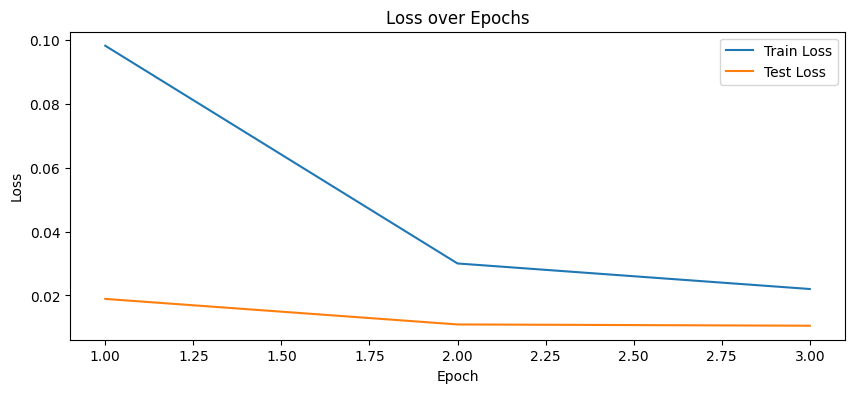

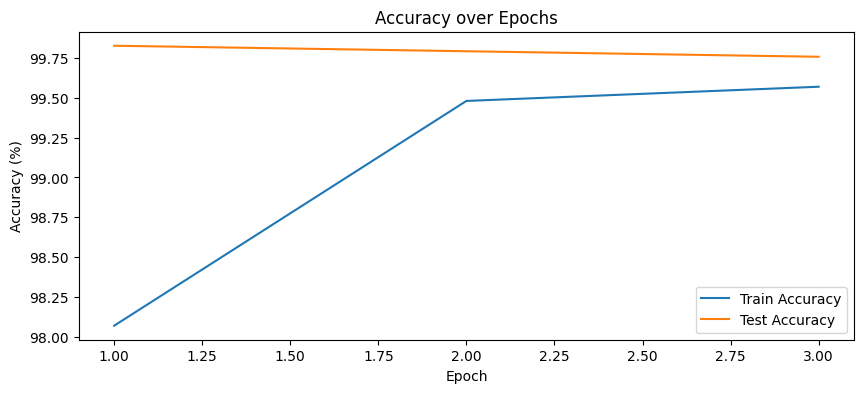

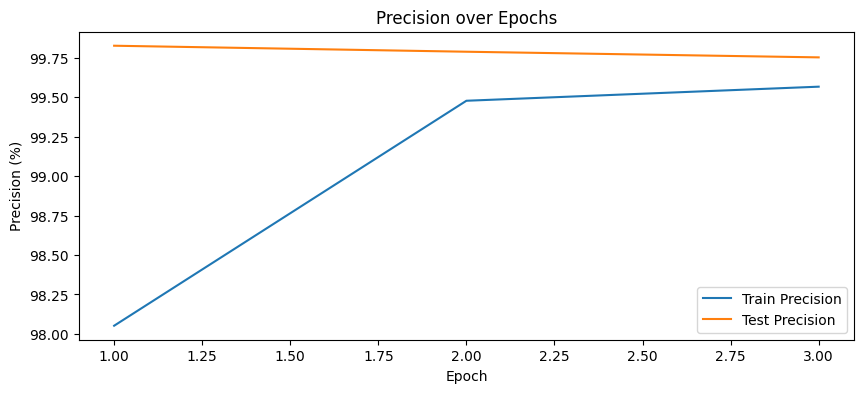

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, total_loss_train_plot, label='Train Loss')
plt.plot(epochs, total_loss_test_plot, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, total_acc_train_plot, label='Train Accuracy')
plt.plot(epochs, total_acc_test_plot, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(10, 4))
plt.plot(epochs, total_precision_train_plot, label='Train Precision')
plt.plot(epochs, total_precision_test_plot, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision (%)')
plt.title('Precision over Epochs')
plt.legend()
plt.show()

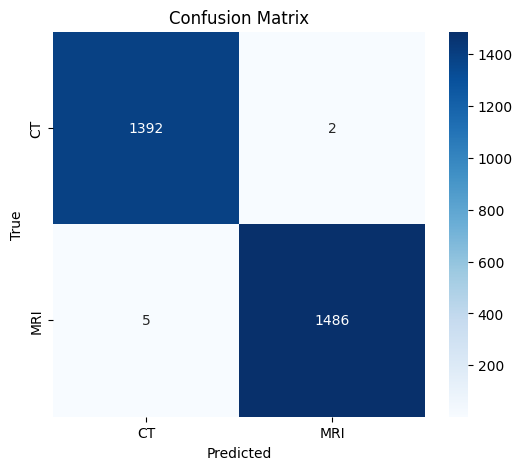

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# After test phase
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CT', 'MRI'], yticklabels=['CT', 'MRI'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()